<text> INSPER - Big Data e Computação em Nuvem <text>
    
<text> Grupo 1: André Gambry, Mainara Cardoso, Tiago Pardo <text>

    
<span style="font-size: 40px;">Big Data e Computação em Nuvem - Projeto Final.</span>


<span style="font-size: 30px;">Objetivo do projeto: Previsão de cancelamento de vôos por condições meteorológicas</span>
    
<span style="font-size: 20px;">Fonte de Dados:</span>
    
    Airline Delay: https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018
    Airports.csv: https://github.com/PacktPublishing/Pandas-Cookbook/blob/master/data/descriptions/airports.csv?plain=1
    Weather: https://github.com/adambry/Projeto_Final_BigData/blob/main/df_weather.csv
    
    
<text> OBS: </text>   
<text> Os dados de Weather foram obtidos via Web Scrapping do site: https://www.ncei.noaa.gov/ </text>

<text> Os dados de Airports foram obtidos através de download pelo site: https://ourairports.com/data/ </text>

    
    




# BIBLIOTECAS, SESSÃO SPARK E IMPORTAÇÃO DE DADOS




## Importação de bibliotecas

In [15]:
from pyspark.sql.functions import dayofmonth, col, expr, year, month, date_format, when, countDistinct, trim, lower,  lit
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from io import StringIO
import requests
import pandas as pd
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Sessão Spark

In [6]:
spark = (SparkSession
            .builder
            .master("local[4]")
            .appName("Projeto Final")
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6")
            .config("spark.driver.memory", "4g")
            .config("spark.executor.memory", "5g")
            .getOrCreate())

In [7]:
sc = spark.sparkContext
#sc._conf.getAll()

## Importação dos dados

### Base "airline delay"

In [4]:
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

<font color = red> 
    No snipet abaixo estamos importanto dados apenas para o arquivo do ano de 2011. Ajustar para importar dos demais anos
    <font> 

In [33]:
# config = spark.sparkContext._jsc.hadoopConfiguration()
# config.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

# df_airline_delay = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2011.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, inferSchema=True)

# df_airline_delay.limit(5).toPandas()

In [18]:
# Lista de anos da base que utilizaremos
anos = list(range(2009,2016))

#Criando objeto ao qual será atribuída a tabela final
df_airline_delay = None

# iterando nos arquivos e salvando no objeto df_airline_delay
for ano in anos:
    caminho_arquivo = "wasbs://{}@{}.blob.core.windows.net/{}/{}.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER, ano)
    
    df_temp = spark.read.csv(caminho_arquivo, header=True, inferSchema=True)
    
    if df_airline_delay is None:
        df_airline_delay = df_temp
    else:
        df_airline_delay = df_airline_delay.union(df_temp)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,WN,3293,PHX,SAT,850.0,851.0,1.0,10.0,901.0,...,125.0,114.0,102.0,843.0,NaN,NaN,NaN,NaN,NaN,None
1,2009-01-01,WN,175,RNO,LAS,1345.0,1356.0,11.0,12.0,1408.0,...,75.0,72.0,55.0,345.0,NaN,NaN,NaN,NaN,NaN,None
2,2009-01-01,WN,2372,SFO,LAS,1830.0,1825.0,-5.0,7.0,1832.0,...,85.0,80.0,66.0,414.0,NaN,NaN,NaN,NaN,NaN,None
3,2009-01-01,EV,5337,DHN,ATL,1347.0,1341.0,-6.0,5.0,1346.0,...,57.0,51.0,33.0,171.0,NaN,NaN,NaN,NaN,NaN,None
4,2009-01-01,FL,150,BWI,MIA,850.0,852.0,2.0,8.0,900.0,...,153.0,146.0,133.0,946.0,NaN,NaN,NaN,NaN,NaN,None
5,2009-01-01,MQ,3135,SJC,LAX,2110.0,NaN,NaN,NaN,NaN,...,75.0,NaN,NaN,308.0,NaN,NaN,NaN,NaN,NaN,None
6,2009-01-01,MQ,3619,DFW,GSP,640.0,701.0,21.0,15.0,716.0,...,135.0,126.0,107.0,862.0,NaN,NaN,NaN,NaN,NaN,None
7,2009-01-01,NW,519,LGA,MSP,2000.0,1949.0,-11.0,15.0,2004.0,...,186.0,181.0,159.0,1020.0,NaN,NaN,NaN,NaN,NaN,None
8,2009-01-01,NW,1222,DTW,MBS,2259.0,2301.0,2.0,18.0,2319.0,...,53.0,44.0,23.0,98.0,NaN,NaN,NaN,NaN,NaN,None
9,2009-01-01,9E,2505,MLI,DTW,1802.0,1752.0,-10.0,12.0,1804.0,...,94.0,86.0,60.0,373.0,NaN,NaN,NaN,NaN,NaN,None


In [19]:
df_airline_delay.cache()

DataFrame[FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: double, DEP_TIME: double, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: double, WHEELS_ON: double, TAXI_IN: double, CRS_ARR_TIME: double, ARR_TIME: double, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, Unnamed: 27: string]

In [39]:
df_airline_delay.count()

43051239

### Base "weather"

In [40]:
# URL do arquivo no GitHub
url = "https://github.com/adambry/Projeto_Final_BigData/raw/main/df_weather.csv"

df_weather = pd.read_csv(url)

df_weather = spark.createDataFrame(df_weather)

df_weather.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,State,Year,Month,tavg,pcp
0,Alabama,2018,December,49.0,9.95
1,Alabama,2018,November,50.4,6.29
2,Alabama,2018,October,67.4,2.69
3,Alabama,2018,September,79.4,6.21
4,Alabama,2018,August,79.5,5.03


In [41]:
#verificando ocorrência de duplicadas na base
df_weather_duplicadas = df_weather.groupBy("State", "Year","Month", "tavg", "pcp").count().filter(col("count") > 1)

df_weather_duplicadas.count()

5880

Verificamos que a importação dos dados via o WebScrapping duplicou cada valor na base. Portanto, removeremos as duplicadas.

In [42]:
df_weather = df_weather.dropDuplicates()

df_weather.count()

5880

Filtrando dados do ano de 2009 a 2016

In [43]:
df_weather = df_weather.filter((col("Year") >= 2009) & (col("Year") <= 2016))

df_weather.select('Year').distinct().toPandas()

,Year
0,2014
1,2012
2,2016
3,2010
4,2009
5,2013
6,2011
7,2015


### Base "airports"

In [44]:
url = 'https://raw.githubusercontent.com/adambry/Projeto_Final_BigData/main/Aeroportos_US.csv'

# Especifique as colunas de interesse
df_airports_region = pd.read_csv(url, delimiter=';')

df_airports_region = spark.createDataFrame(df_airports_region)

df_airports_region.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,type,name,iso_country,iso_region,iata_code
0,small_airport,Ocean Reef Club Airport,US,FL,OCA
1,small_airport,Pilot Station Airport,US,AK,PQS
2,small_airport,Crested Butte Airpark,US,CO,CSE
3,small_airport,LBJ Ranch Airport,US,TX,JCY
4,small_airport,Nunapitchuk Airport,US,AK,NUP


# TRATAMENTO DOS DADOS

## Limpeza dos aeroportos fora dos EUA

In [45]:
# Estudo da base para verificar se os estados registrados na coluna STATE na base df_airports_region estão corretos
df_airports_region.select("iso_region").distinct().count()

51

Sabemos que os Estados Unidos possuem 50 estados. Poranto, precisamos vamos identificar os excedentes e retirá-los da base

In [46]:
# identificando Estados Excedentes

# Lista de estados dos EUA (https://pt.wikipedia.org/wiki/Estados_dos_Estados_Unidos)
us_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Filtra os estados excedentes
excess_states = df_airports_region.select("iso_region").distinct().filter(~col("iso_region").isin(us_states))

# Exibe os estados excedentes
excess_states.show()


+----------+
|iso_region|
+----------+
|        DC|
+----------+



Verificando quais aeroportos estão nos Estados não identificados

In [47]:
# Filtra os aeroportos com base nos estados excedentes
df_excess_airports = df_airports_region.filter(col("iso_region").isin([row.iso_region for row in excess_states.collect()]))

# Exibe os aeroportos nos estados excedentes
df_excess_airports.show(truncate=False)

+-------------+-----------------------------------------+-----------+----------+---------+
|type         |name                                     |iso_country|iso_region|iata_code|
+-------------+-----------------------------------------+-----------+----------+---------+
|large_airport|Ronald Reagan Washington National Airport|US         |DC        |DCA      |
+-------------+-----------------------------------------+-----------+----------+---------+



A partir de consultas na internet, verificamos que este aeroporto fica em Washginton. Portanto, a iso_region deve ser alterado para WA, sigla do Estado.

In [48]:
# Substitui o valor "DC" por "WA" na coluna "iso_region"
df_airports_region = df_airports_region.withColumn("iso_region", when(col("iso_region") == "DC", "WA").otherwise(col("iso_region")))

# Exibe os aeroportos após a substituição
df_airports_region.select("iso_region").distinct().count()

50

## Transformação

### Tabela df_airports_region

Transformação da sigla dos estados para o nome por extenso para corresponder aos valores da tabela df_weather

In [49]:
state_full_name = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

# Criar a nova coluna com nomes de estados por extenso
df_airports_region = df_airports_region.withColumn("STATE_FULL_NAME", col("iso_region").cast("string")).replace(state_full_name, subset="STATE_FULL_NAME")

# Exibir o DataFrame resultante
df_airports_region.limit(5).toPandas()

,type,name,iso_country,iso_region,iata_code,STATE_FULL_NAME
0,small_airport,Ocean Reef Club Airport,US,FL,OCA,Florida
1,small_airport,Pilot Station Airport,US,AK,PQS,Alaska
2,small_airport,Crested Butte Airpark,US,CO,CSE,Colorado
3,small_airport,LBJ Ranch Airport,US,TX,JCY,Texas
4,small_airport,Nunapitchuk Airport,US,AK,NUP,Alaska


Retiraremos todos os espaços antes e depois das strings que utilizaremos para join e as deixaremos em snakecase.

In [50]:
df_airports_region = df_airports_region.withColumn("STATE_FULL_NAME", trim("STATE_FULL_NAME"))
df_airports_region = df_airports_region.withColumn("STATE_FULL_NAME", lower("STATE_FULL_NAME"))
df_airports_region = df_airports_region.withColumn("iata_code", trim("iata_code"))
df_airports_region = df_airports_region.withColumn("iata_code", lower("iata_code"))
df_airports_region.limit(5).toPandas()

,type,name,iso_country,iso_region,iata_code,STATE_FULL_NAME
0,small_airport,Ocean Reef Club Airport,US,FL,oca,florida
1,small_airport,Pilot Station Airport,US,AK,pqs,alaska
2,small_airport,Crested Butte Airpark,US,CO,cse,colorado
3,small_airport,LBJ Ranch Airport,US,TX,jcy,texas
4,small_airport,Nunapitchuk Airport,US,AK,nup,alaska


### Tabela airline_delay

Retiraremos todos os espaços antes e depois das strings que utilizaremos para join e as deixaremos em snakecase.

In [51]:
df_airline_delay = df_airline_delay.withColumn("ORIGIN", trim("ORIGIN"))
df_airline_delay = df_airline_delay.withColumn("ORIGIN", lower("ORIGIN"))
df_airline_delay.select("ORIGIN").limit(5).toPandas()

,ORIGIN
0,dca
1,ewr
2,ewr
3,dca
4,iad


Criando colunas de ano e mês a partir da FL_DATE na tabela df_airline_delay

In [52]:
df_airline_delay = df_airline_delay.withColumn("Year", year("FL_DATE")).withColumn("Month", date_format(col("FL_DATE"), "MMMM"))
df_airline_delay.select("FL_DATE","Year", "Month").limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,Year,Month
0,2009-01-01,2009,January
1,2009-01-01,2009,January
2,2009-01-01,2009,January
3,2009-01-01,2009,January
4,2009-01-01,2009,January


Fazendo Sample da base para diminuir a quantidade de linhas

In [53]:
df_airline_delay = df_airline_delay.sample(fraction = 0.1, seed = 123)

### Tabela Weather

Variável State para snakecase e retirada de eventuais espaços antes e/ou depois da string

In [54]:
df_weather = df_weather.withColumn("State", trim("State"))
df_weather = df_weather.withColumn("State", lower("State"))
df_weather.limit(5).toPandas()

,State,Year,Month,tavg,pcp
0,alabama,2016,January,43.0,4.06
1,arizona,2012,June,78.7,0.08
2,arizona,2009,February,46.6,1.02
3,colorado,2016,May,50.8,2.07
4,florida,2013,August,82.2,7.56


## Join nas tabelas


### Join nas tabelas df_airport_region e df_airline_delay

In [55]:
df_airline_delay_airports = df_airline_delay.join(df_airports_region, df_airline_delay.ORIGIN == df_airports_region.iata_code, "inner")

df_airline_delay_airports.count()

4281693

### Join nas tabelas df_airline_delay_airports e df_weather

Criando dataframe que será utilizado no pipeline

In [56]:
df = df_airline_delay_airports.join(df_weather, (df_airline_delay_airports.STATE_FULL_NAME == df_weather.State) & (df_airline_delay_airports.Year == df_weather.Year) & (df_airline_delay_airports.Month == df_weather.Month), "inner")

df.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,name,iso_country,iso_region,iata_code,STATE_FULL_NAME,State,Year,Month,tavg,pcp
0,2009-01-01,WN,595,isp,MDW,1240.0,1313.0,33.0,6.0,1319.0,...,Long Island Mac Arthur Airport,US,NY,isp,new york,new york,2009,January,15.0,2.53
1,2009-01-01,WN,1252,isp,MDW,1755.0,1802.0,7.0,8.0,1810.0,...,Long Island Mac Arthur Airport,US,NY,isp,new york,new york,2009,January,15.0,2.53
2,2009-01-02,WN,2889,isp,MCO,2005.0,2002.0,-3.0,7.0,2009.0,...,Long Island Mac Arthur Airport,US,NY,isp,new york,new york,2009,January,15.0,2.53
3,2009-01-02,WN,595,isp,MDW,1240.0,1248.0,8.0,14.0,1302.0,...,Long Island Mac Arthur Airport,US,NY,isp,new york,new york,2009,January,15.0,2.53
4,2009-01-02,WN,1252,isp,MDW,1755.0,1813.0,18.0,10.0,1823.0,...,Long Island Mac Arthur Airport,US,NY,isp,new york,new york,2009,January,15.0,2.53


Verificando se todos os valores corresponderam entre as duas tabelas

In [60]:
df_erro = df_airline_delay_airports.join(df_weather, (df_airline_delay_airports.STATE_FULL_NAME == df_weather.State) & (df_airline_delay_airports.Year == df_weather.Year) & (df_airline_delay_airports.Month == df_weather.Month), "left")

In [61]:
#Verificando falhas no Join

unmatched_rows = df_erro.filter(col("State").isNull())

# Contagem das linhas não correspondidas
unmatched_rows.count()

73327

In [62]:
unmatched_rows.limit(5).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,name,iso_country,iso_region,iata_code,STATE_FULL_NAME,State,Year,Month,tavg,pcp
0,2009-01-01,HA,110,lih,HNL,719.0,712.0,-7.0,7.0,719.0,...,Lihue Airport,US,HI,lih,hawaii,None,NaN,None,NaN,NaN
1,2009-01-01,HA,140,lih,HNL,1118.0,1114.0,-4.0,10.0,1124.0,...,Lihue Airport,US,HI,lih,hawaii,None,NaN,None,NaN,NaN
2,2009-01-01,HA,184,lih,HNL,1616.0,1609.0,-7.0,6.0,1615.0,...,Lihue Airport,US,HI,lih,hawaii,None,NaN,None,NaN,NaN
3,2009-01-02,HA,124,lih,HNL,840.0,833.0,-7.0,7.0,840.0,...,Lihue Airport,US,HI,lih,hawaii,None,NaN,None,NaN,NaN
4,2009-01-02,HA,184,lih,HNL,1616.0,1609.0,-7.0,6.0,1615.0,...,Lihue Airport,US,HI,lih,hawaii,None,NaN,None,NaN,NaN


In [63]:
# Seleciona os nomes únicos na coluna 'STATE_FULL_NAME'
unique_states = unmatched_rows.select('STATE_FULL_NAME').distinct()

# Mostra os resultados
unique_states.show()

+---------------+
|STATE_FULL_NAME|
+---------------+
|         hawaii|
+---------------+



<font color = red> Podemos comentar no começo que na nossa base externa não tem informações do hawaii e por isso retiramos da nossa base? <font>

Considerando que a base possui mais de 6 milhões de registros, não aprofundaremos em entender as 101304 que não corresponderam entre as tabelas.

# Criação da variável resposta ('WEATHER_DELAY_BIN')

Nosso objetivo é fazer uma previsão de classificação dos voos que irão atrasar por motivo do tempo. Para isso, vamos criar uma variável binária com base na variável que mensura o tempo de atraso de um voo por motivo de tempo.

In [64]:
df = df.withColumn('WEATHER_DELAY_BIN', when(col('WEATHER_DELAY') > 0, 1).otherwise(0))

# Análise Descritiva

## Verificando a distribuição da variável resposta

In [65]:
# Contar a frequência de cada valor na variável resposta
dist_respost = df.groupBy('WEATHER_DELAY_BIN').count().orderBy('WEATHER_DELAY_BIN')

# Mostrar os resultados
dist_respost.show()

+-----------------+-------+
|WEATHER_DELAY_BIN|  count|
+-----------------+-------+
|                0|4163340|
|                1|  45026|
+-----------------+-------+



## Análise Univariada

### Variáveis numéricas

<font color=red> criar aqui gráficos para visualizarmos a dispersão dos dados em boxplot para as colunas numéricas pertinentes <font>

#### Precipicitação (Voo atrasado por tempo x Voo sem atraso por tempo)

<Figure size 1000x600 with 0 Axes>

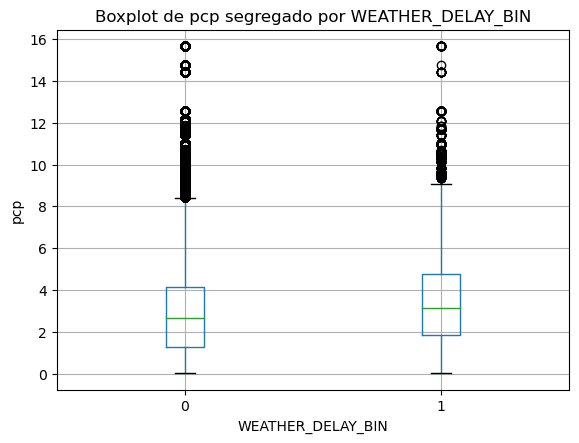

In [66]:
df_pcp = df.select('pcp', 'WEATHER_DELAY_BIN').toPandas()

# Cria um boxplot
plt.figure(figsize=(10, 6))
df_pcp.boxplot(by='WEATHER_DELAY_BIN', column=['pcp'])
plt.title('Boxplot de pcp segregado por WEATHER_DELAY_BIN')
plt.suptitle('')
plt.xlabel('WEATHER_DELAY_BIN')
plt.ylabel('pcp')
plt.show()

#### Tavg (Voo atrasado por tempo x Voo sem atraso por tempo)

<Figure size 1000x600 with 0 Axes>

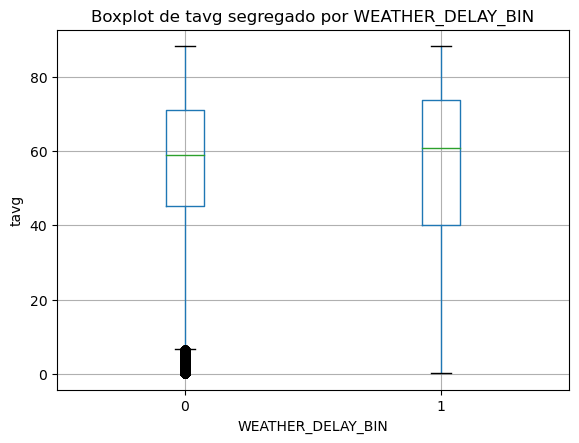

In [67]:
df_tavg = df.select('tavg', 'WEATHER_DELAY_BIN').toPandas()

# Cria um boxplot
plt.figure(figsize=(10, 6))
df_tavg.boxplot(by='WEATHER_DELAY_BIN', column=['tavg'])
plt.title('Boxplot de tavg segregado por WEATHER_DELAY_BIN')
plt.suptitle('')
plt.xlabel('WEATHER_DELAY_BIN')
plt.ylabel('tavg')
plt.show()

In [68]:
# Agrupar e contar atrasos por aeroporto de origem
atrasos_origem = df.groupBy('ORIGIN').agg({'WEATHER_DELAY_BIN': 'sum'}).withColumnRenamed('sum(WEATHER_DELAY_BIN)', 'Total_Atrasos').orderBy(col('Total_Atrasos').desc())

# Agrupar e contar atrasos por aeroporto de destino
atrasos_destino = df.groupBy('DEST').agg({'WEATHER_DELAY_BIN': 'sum'}).withColumnRenamed('sum(WEATHER_DELAY_BIN)', 'Total_Atrasos').orderBy(col('Total_Atrasos').desc())

# Visualização
origem_pandas = atrasos_origem.toPandas()
destino_pandas = atrasos_destino.toPandas()

In [69]:
# Contar o número total de aeroportos distintos em cada caso
total_aeroportos_origem = atrasos_origem.count()
total_aeroportos_destino = atrasos_destino.count()

# Calcular 10% dos aeroportos
top_10_percent_origem = int(total_aeroportos_origem * 0.1)
top_10_percent_destino = int(total_aeroportos_destino * 0.1)

# Selecionar os top 10% aeroportos
top_atrasos_origem = atrasos_origem.limit(top_10_percent_origem)
top_atrasos_destino = atrasos_destino.limit(top_10_percent_destino)

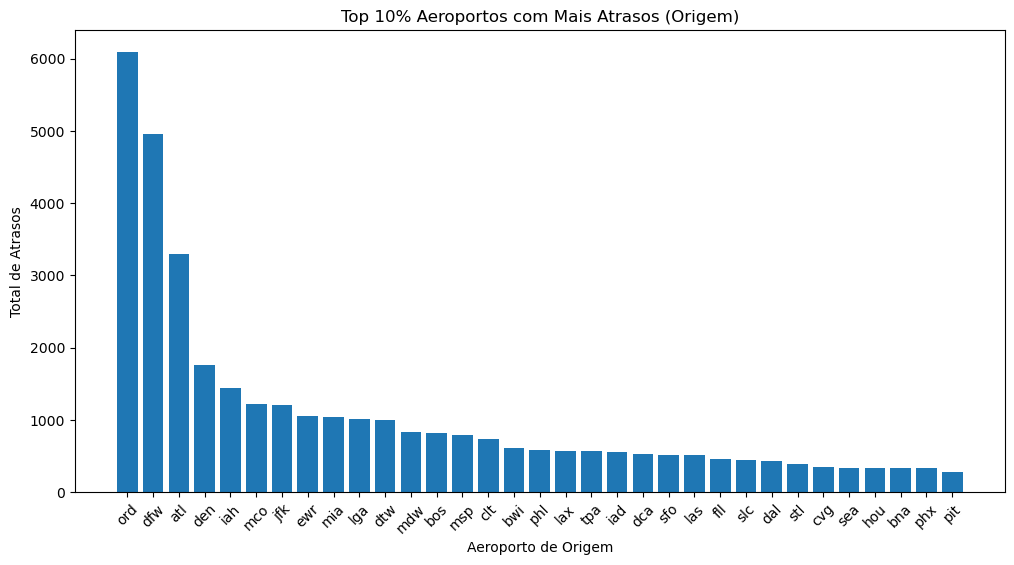

In [70]:
# Convertendo para Pandas
top_atrasos_origem_pd = top_atrasos_origem.toPandas()
top_atrasos_destino_pd = top_atrasos_destino.toPandas()

# Plotando para Origem
plt.figure(figsize=(12, 6))
plt.bar(top_atrasos_origem_pd['ORIGIN'], top_atrasos_origem_pd['Total_Atrasos'])
plt.xlabel('Aeroporto de Origem')
plt.ylabel('Total de Atrasos')
plt.title('Top 10% Aeroportos com Mais Atrasos (Origem)')
plt.xticks(rotation=45)
plt.show()

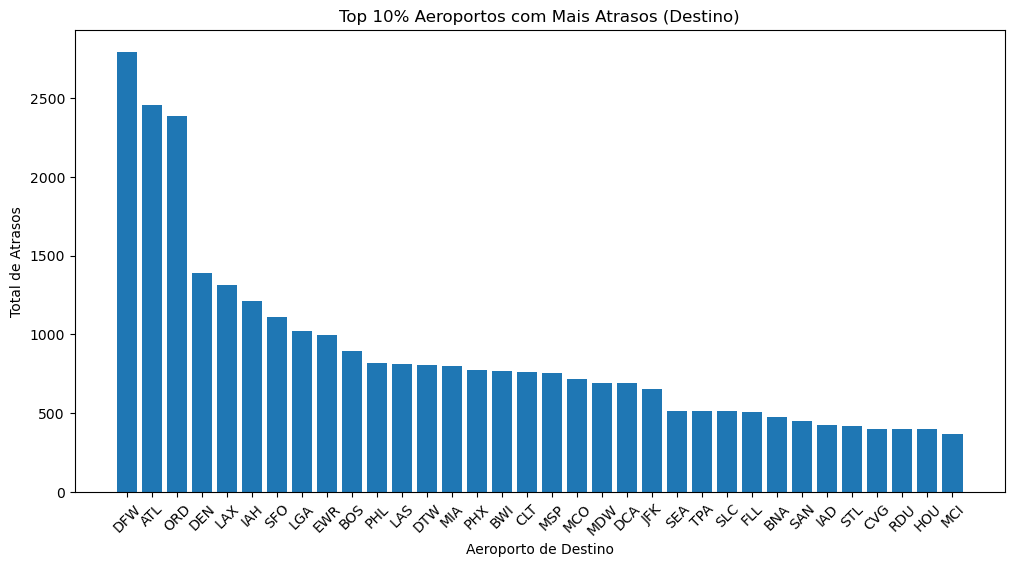

In [71]:
# Plotando para Destino
plt.figure(figsize=(12, 6))
plt.bar(top_atrasos_destino_pd['DEST'], top_atrasos_destino_pd['Total_Atrasos'])
plt.xlabel('Aeroporto de Destino')
plt.ylabel('Total de Atrasos')
plt.title('Top 10% Aeroportos com Mais Atrasos (Destino)')
plt.xticks(rotation=45)
plt.show()

### Variáveis categóricas

<font color=red> criar aqui gráficos para visualizarmos a frequência das categorias para cada variável <font>

# Análise Exploratória

## Criação de hipóteses

<font color = red> criar aqui hipóteses subjetivas (de acordo com nossa interpretação subjetivas sobre os dados) de como as variáveis se comportam frente à variável resposta <font>
    
    Por exemplo: 
    1. Vôos entre aeroportos mais distantes tendem a ter mais atrasos por 'weather'
    2. O número de vôos cancelados por motivos de 'weather' é maior em meses que possuem maior precipitação



## Análise Bivariada

<font color=red> criar gráficos buscando responder as hipóteses criadas 
    <font>

Isso é útil para criarmos uma intuição sobre a importância das variáveis nos modelos e obter maior autonomia para manipulação, evitando que nos tornemos totalmente dependente somente de algorítmos para seleção de variáveis, por exemplo.

### Calculando % atraso em cada faixa

<font color = red> necessita ajuste para pegar apenas vôos cancelados por motivo de 'weather'

In [ ]:
# frequencia_absoluta = df_classificacao_distancias.groupBy("CLASSIFICACAO_DISTANCIAS").count()
# total_atrasos = df_classificacao_distancias.count()

# frequencia_absoluta.show()
# total_atrasos

In [ ]:
# porcentagem_atrasos_por_classificacao_distancia = frequencia_absoluta.withColumn(
#     "PORCENTAGEM",
#     expr("count / {} * 100".format(total_atrasos))
# )

# porcentagem_atrasos_por_classificacao_distancia.show()

### Número de vôos diários

In [ ]:
# # Plotando gráfico com o número de vôos diários

# plt.figure(figsize=(15,8))
# ax = sns.lineplot(data=df_BOS_agrupado_data_pandas, x='FL_DATE', y='count')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
# ax.set(title='Número Diário de Voos',
#        xlabel='Data',
#        ylabel='Número de Voos')

# plt.show()

# Análise Multivariada

# FEATURE ENGINEERING

In [ ]:
# Fazendo variável com valor dos percentis 0.33 e 0.66 para posteriormente segmentar as distâncias.
# documentação consultada: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.approxQuantile.html

# percentis = df.stat.approxQuantile("DISTANCE", [0.33, 0.66], 0.01)

In [ ]:
# Criando coluna no dataframe para classificação das distâncias a partir dos percentis calculados
# Foi utilizado o percentis[0] para acessar os valor do percentil 0.33 e percentis[1] para acessar o valor de percentis 0.66.
''' Foi necessário utilizar o recurso de format ao invés de utilizar diretamente a referência do objetos da variável percentis no corpo da expressão porque, de outra forma, o 
PySpark interpretou percentis[0] e percentis[1] como literais de string, e não como valores da lista criada na variável percentis'''

# df_classificacao_distancias = df.withColumn(
#     'CLASSIFICACAO_DISTANCIAS',
#     expr(
#         "CASE WHEN distance <= {} THEN 'proximos'"
#         " WHEN distance <= {} THEN 'medio'"
#         " ELSE 'distantes' END".format(percentis[0], percentis[1])
#     )
# )

# df_classificacao_distancias.show(10)                               

## Criação da variável resposta ('WEATHER_DELAY_BIN')

Nosso objetivo é fazer uma previsão de classificação dos voos que irão atrasar por motivo do tempo. Para isso, vamos criar uma variável binária com base na variável que mensura o tempo de atraso de um voo por motivo de tempo.

In [ ]:
df = df.withColumn('WEATHER_DELAY_BIN', when(col('WEATHER_DELAY') > 0, 1).otherwise(0))

## Drop de colunas irrelevantes

Considerando nossa variável resposta, serão removidas as variáveis que não são relevantes para o nosso problema e aumentam o gasto computacional.

In [ ]:
# Drop de colunas irrelavantes

drop_cols = 'CANCELLED', 'CANCELLATION_CODE','CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'OP_CARRIER_FL_NUM', 'iso_region', 'iso_country', 'STATE_FULL_NAME', 'FL_DATE', 'iata_code', 'Unnamed: 27','Year', 'Month', 'DIVERTED'

df = df.drop(*drop_cols)

df.limit(5).toPandas()

## Análise de campos ausentes

In [ ]:
from pyspark.sql.functions import col, lit, sum as _sum

# Criar uma coluna que indica se a linha tem algum valor nulo
df_with_null_flag = df.withColumn('has_null', sum(col(c).isNull().cast("int") for c in df.columns))

# Contar o número total de linhas e o número de linhas com valor nulo
total_rows = df_with_null_flag.count()
null_rows = df_with_null_flag.filter(col('has_null') > 0).count()

# Calcular a proporção de linhas com valor nulo
null_proportion = null_rows / total_rows

# Imprimir os resultados
print(f"Total de linhas: {total_rows}")
print(f"Linhas com pelo menos um valor nulo: {null_rows}")
print(f"Proporção de linhas com valor nulo: {null_proportion:.2f}")

In [ ]:
from pyspark.sql.functions import col

# Criar uma condição para verificar se não há valores nulos em cada coluna
condition = " AND ".join([f"{c} IS NOT NULL" for c in df.columns])

# Filtrar o DataFrame para manter apenas as linhas sem valores nulos
df = df.filter(condition)

## Train/Test Split

In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
toy_df = test_df.sample(False, 0.01, seed=42)

In [ ]:
print("Train set count: ", train_df.count())
print("Test set count:", test_df.count())
print("Toy df count:", toy_df.count())

## Feature Engineering: One-Hot-Encoding

In [ ]:
#Preparção de dados categóricos 


cat_feats = ['OP_CARRIER', 'ORIGIN', 'DEST', 'type', 'name', 'State']

indexOutputCols = [x + "Index" for x in cat_feats] #adiciona um sufixo INDEX para identificar col
oheOutputCols = [x + "OHE" for x in cat_feats] #Adiciona o sufixo OHE na col que irá receber OHE

stringIndexer = StringIndexer(inputCols = cat_feats,
                              outputCols = indexOutputCols,
                              handleInvalid = "skip") #criando os indexes e armazenando na col indexOutput

oheEncoder = OneHotEncoder(inputCols = indexOutputCols, outputCols = oheOutputCols)

## Feature Engineering: Feature Normalization

In [ ]:
num_feats = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE']

numVecAssembler = VectorAssembler(inputCols = num_feats, outputCol = "features")

stdScaler = StandardScaler(inputCol='features', outputCol='features_scaled')

## Assembling dos vetores

In [ ]:
#Preparação da coluna final com os vetores do modelo

assemblerInputs = oheOutputCols + ['features_scaled']

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features_vector", handleInvalid="skip") 

In [ ]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stdScaler, vecAssembler]

## Visualizando as transformações

In [ ]:
# Criação do pipeline de transformação
transform_pipeline =  Pipeline(stages=stages)

# Aplicação do pipeline nos dados de treino - ajuste da transformação
fitted_transformer = transform_pipeline.fit(train_df)

#Aplicação da transformação nos dados de treino
transformed_train_df = fitted_transformer.transform(train_df)
transformed_train_df.limit(10).toPandas()

# Criação do Pipeline

## Regressão Logística

In [ ]:
model = LogisticRegression(maxIter=50,
                         labelCol='WEATHER_DELAY_BIN', 
                         featuresCol='features_vector',
                         elasticNetParam=0.2,
                         regParam=0.02)

pipe_stages = stages + [model]

pipe = Pipeline(stages=pipe_stages)

## Model Training

In [ ]:
fitted_pipe = pipe.fit(train_df)

## Model performance evaluation

In [ ]:
preds = fitted_pipe.transform(test_df)

In [ ]:
preds.limit(10).toPandas()

In [ ]:
# Acurácia
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='WEATHER_DELAY_BIN', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(preds)
print('Acurácia:', accuracy)

# AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol='WEATHER_DELAY_BIN', rawPredictionCol='prediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(preds)
print('AUC:', auc)

In [ ]:
# Converter o DataFrame para um RDD necessário para o MulticlassMetrics
predictionAndLabels = preds.select(['prediction', 'WEATHER_DELAY_BIN']).rdd.map(lambda row: (float(row[0]), float(row[1])))

# Inicializar MulticlassMetrics com as previsões e os rótulos
metrics = MulticlassMetrics(predictionAndLabels)

# Matriz de Confusão
confusion_matrix = metrics.confusionMatrix().toArray()
print("Matriz de Confusão:")
print(confusion_matrix)

# Cálculo de Sensibilidade e Especificidade
sensibilidade = metrics.recall(1.0)
especificidade = metrics.truePositiveRate(0.0)

print('Sensibilidade:', sensibilidade)
print('Especificidade:', especificidade)

## Hyperparameter Tuning

In [ ]:
# Construção da grade de parâmetros
parameter_grid = ParamGridBuilder() \
                 .addGrid(model.elasticNetParam, [0.2, 0.3]) \
                 .addGrid(model.regParam, [0.02, 0.03]) \
                 .build()

# Avaliador para classificação
evaluator = BinaryClassificationEvaluator(labelCol='WEATHER_DELAY_BIN', metricName='areaUnderROC')

# CrossValidator
cross_val = CrossValidator(estimator=pipe,
                           estimatorParamMaps=parameter_grid,
                           evaluator=evaluator, 
                           numFolds=5)

cv_model = cross_val.fit(toy_df)  


In [ ]:
en = [0.2, 0.3]
reg = [0.02, 0.03]
elastic_net = [e for e in en for r in reg]
regularization = [r for e in en for r in reg]

# Criando um DataFrame para visualizar os resultados
metrics_df = pd.DataFrame({'areaUnderROC': cv_model.avgMetrics,
                           'elastic_net_alpha': elastic_net, 
                           'regularization_term': regularization})

# Ordenando os resultados
sorted_metrics_df = metrics_df.sort_values(by='areaUnderROC', ascending=False)

print(sorted_metrics_df)

<font color=red>NAO ALTEREI ESSES PONTOS ABAIXO <font>

# 4 Análise Descritiva

## 4.1. Análise Univariada

### 4.1.1. Variáveis numéricas

<font color=red> criar aqui gráficos para visualizarmos a dispersão dos dados em boxplot para as colunas numéricas pertinentes <font>

### 4.1.2. Variáveis categóricas

<font color=red> criar aqui gráficos para visualizarmos a frequência das categorias para cada variável <font>

# 5. Análise Exploratória

## 5.1 Criação de hipóteses

<font color = red> criar aqui hipóteses subjetivas (de acordo com nossa interpretação subjetivas sobre os dados) de como as variáveis se comportam frente à variável resposta <font>
    
    Por exemplo: 
    1. Vôos entre aeroportos mais distantes tendem a ter mais atrasos por 'weather'
    2. O número de vôos cancelados por motivos de 'weather' é maior em meses que possuem maior precipitação



## 5.2. Análise Bivariada

<font color=red> criar gráficos buscando responder as hipóteses criadas 
    <font>

Isso é útil para criarmos uma intuição sobre a importância das variáveis nos modelos e obter maior autonomia para manipulação, evitando que nos tornemos totalmente dependente somente de algorítmos para seleção de variáveis, por exemplo.

### 5.2.1. Calculando % atraso em cada faixa

<font color = red> necessita ajuste para pegar apenas vôos cancelados por motivo de 'weather'

In [ ]:
# frequencia_absoluta = df_classificacao_distancias.groupBy("CLASSIFICACAO_DISTANCIAS").count()
# total_atrasos = df_classificacao_distancias.count()

# frequencia_absoluta.show()
# total_atrasos

In [ ]:
# porcentagem_atrasos_por_classificacao_distancia = frequencia_absoluta.withColumn(
#     "PORCENTAGEM",
#     expr("count / {} * 100".format(total_atrasos))
# )

# porcentagem_atrasos_por_classificacao_distancia.show()

### 5.1.2. Número de vôos diários

In [ ]:
# # Plotando gráfico com o número de vôos diários

# plt.figure(figsize=(15,8))
# ax = sns.lineplot(data=df_BOS_agrupado_data_pandas, x='FL_DATE', y='count')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
# ax.set(title='Número Diário de Voos',
#        xlabel='Data',
#        ylabel='Número de Voos')

# plt.show()

# 5.2. Análise Multivariada

# 6. Modelagem de Machine Learning

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [ ]:
cols = ['ORIGIN', 'DEST', 'State', 'tavg', 'pcp', 'WEATHER_DELAY_BIN']
df_ml = df.select(*cols)

df_ml_sample = df_ml.sample(fraction=0.1, seed=3)

cat_columns = ['ORIGIN', 'DEST', 'State']
num_columns = ['tavg', 'pcp']

index_output = [x+"Index" for x in cat_columns]
ohe_output = [x+"OHE" for x in cat_columns]

In [ ]:
stringIndexer = StringIndexer(inputCols=cat_columns,
                             outputCols=index_output,
                             handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=index_output,
                          outputCols=ohe_output)

# Montar os recursos em um vetor
assembler = VectorAssembler(inputCols=assemblerInputs,
                     outputCol="features")

In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
(train_data, test_data) = df_ml_sample.randomSplit([0.8, 0.2], seed=1234)

# Criar instâncias dos modelos de Regressão Logística e Floresta Aleatória


## 6.1 Regressão Logística

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='WEATHER_DELAY_BIN')
pipeline_lr = Pipeline(stages=[stringIndexer, oheEncoder, assembler, lr])

model_lr = pipeline_lr.fit(train_data)

predictions_lr = model_lr.transform(test_data)

evaluator_lr = BinaryClassificationEvaluator(labelCol='WEATHER_DELAY_BIN')

evaluation_lr = evaluator_lr.evaluate(predictions_lr)

print(f'AUC:{evaluation_lr}')

## 6.2 Floresta Aleatória

In [ ]:
rf = RandomForestRegressor(featuresCol='features', labelCol='WEATHER_DELAY_BIN')
pipeline_rf = Pipeline(stages=[stringIndexer, oheEncoder, assembler, rf])

model_rf = pipeline_rf.fit(train_data)

predictions_rf = model_rf.transform(test_data)

evaluator_rf = RegressionEvaluator(labelCol="WEATHER_DELAY_BIN", predictionCol="prediction")

evaluation_rf = evaluator_rf.evaluate(predictions_rf)

print(f'RMSE:{evaluation_rf}')

## 6.3 Floresta aleatória com otimização de hiperparâmetros e validação cruzada

In [ ]:
paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [2, 4, 6])
            .addGrid(rf.numTrees, [10, 100])
            .build)

In [ ]:
cv = CrossValidator(
    estimator=pipeline_rf,
    evaluator=evaluator_rf,
    estimatorParamMaps=paramGrid,
    numFolds=5,
    seed=42
)

cvModel = cv.fit(train_data)